<a href="https://colab.research.google.com/github/2359181042/GNN_cs224w/blob/main/%E2%80%9CIreland_wells_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install pytorch_lightning

     |████████████████████████████████| 3.0 MB 4.2 MB/s 
     |████████████████████████████████| 1.6 MB 4.1 MB/s 
     |████████████████████████████████| 222 kB 4.0 MB/s 
     |████████████████████████████████| 376 kB 7.2 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
     |████████████████████████████████| 913 kB 4.3 MB/s 
     |████████████████████████████████| 636 kB 42.6 MB/s 
     |████████████████████████████████| 10.6 MB 38.7 MB/s 
     |████████████████████████████████| 118 kB 53.1 MB/s 
     |████████████████████████████████| 234 kB 46.2 MB/s 
     |████████████████████████████████| 829 kB 41.6 MB/s 
     |████████████████████████████████| 1.3 MB 42.8 MB/s 
     |████████████████████████████████| 142 kB 49.8 MB/s 
     |████████████████████████████████| 294 kB 43.6 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=6bd924fbf56ffa38024006f4fab5ce5cb7a6f84f2ae5409bf97b6eccc4c0cfc0
  Stored in directory: /root/.cache/pip/wh

In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import os
import json
import numpy as np
import pandas as pd
DATA_PATH = 'gdrive/My Drive/Ireland_data/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/gdrive


In [4]:

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib
from matplotlib.pyplot import figure


import pandas as pd
import numpy as np
from tqdm import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid',palette='muted',font_scale = 1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize']=12,8
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# 1. analyze our data 
  #### The data include eight wells between Galway City and Lahinch City in Ireland island. We consider the hourly data from 2016.11.28 13:00-2021.7.1 0:00: groundwater level, thelog_elevation, and the rain, temp and vapour pressure.

In [5]:
df=pd.read_csv(os.path.join(DATA_PATH,'Data1.csv'))
loc=pd.read_csv(os.path.join(DATA_PATH,'sets.csv'))
df['Date'] = pd.to_datetime(df['Time'])
df['Day'] = df['Date'].dt.day
df['Month']=df['Date'].dt.month
df['Year']=df['Date'].dt.year
df['Hour']=df['Date'].dt.hour
df.index=df['Date']
df=df.drop(['Time'],axis=1)
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
cols = df.columns.tolist()
cols = cols[-4:]+cols[:-4]
df=df[cols]
df = df.rename(columns={'Lough Aleenaun': 'O1L', 'Unnamed: 2': 'O1E','Termon South':'O2L','Unnamed: 4':'O2E',  'Coole Lough':'O3L','Unnamed: 6':'O3E', 'Caherglassaun':'O4L','Unnamed: 8':'O4E', 'Black Rock':'O5L', 'Unnamed: 10':'O5E',
                        'Labane':'O6L','Unnamed: 12':'O6E','Caranavoodaun':'O7L', 'Unnamed: 14':'O7E'})


df.columns


Index(['Day', 'Month', 'Year', 'Hour', 'O1L', 'O1E', 'O2L', 'O2E', 'O3L',
       'O3E', 'O4L', 'O4E', 'O5L', 'O5E', 'O6L', 'O6E', 'O7L', 'O7E', 'rain',
       'temp', 'vp', 'Date'],
      dtype='object')

In [ ]:
df.info()

NameError: ignored

In [ ]:
len(df['O2L'])

40140

<Figure size 1280x400 with 0 Axes>

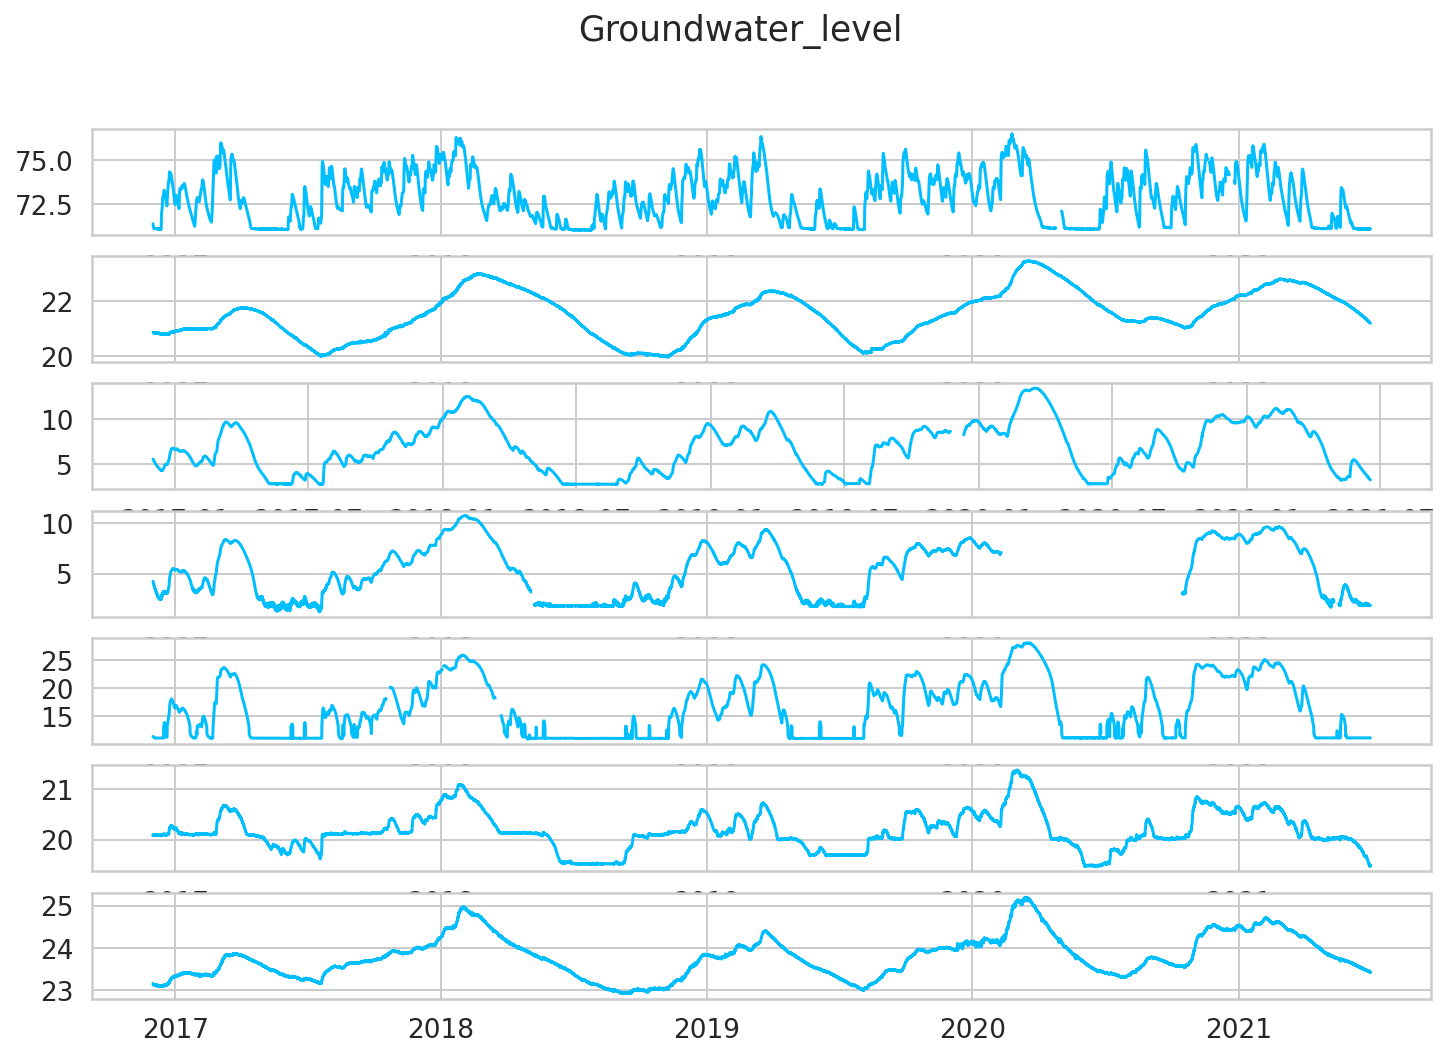

In [ ]:
figure(figsize=(16, 5), dpi=80)
fig, axs = plt.subplots(7)
fig.suptitle('Groundwater_level')
axs[0].plot(df.index, df['O1L'])
axs[1].plot(df.index, df['O2L'])
axs[2].plot(df.index, df['O3L'])
axs[3].plot(df.index, df['O4L'])
axs[4].plot(df.index, df['O5L'])
axs[5].plot(df.index, df['O6L'])
axs[6].plot(df.index, df['O7L'])


In [ ]:
df2.head()

,Day,Month,Year,Hour,O1L,O1E,O2L,O2E,O3L,O3E,O4L,O4E,O5L,O5E,O6L,O6E,O7L,O7E,rain,temp,vp,Date
Date,,,,,,,,,,,,,,,,,,,,,,
2016-12-01 13:00:00,1,12,2016,13,71.365,70.87,20.861,19.73,5.584,2.85,4.242,0.0,11.362,11.08,20.090,19.53,23.154,22.21,0.0,6.5,7.4,2016-12-01 13:00:00
2016-12-01 14:00:00,1,12,2016,14,71.357,70.87,20.864,19.73,5.581,2.85,4.227,0.0,11.358,11.08,20.094,19.53,23.153,22.21,0.0,6.8,7.6,2016-12-01 14:00:00
2016-12-01 15:00:00,1,12,2016,15,71.348,70.87,20.863,19.73,5.574,2.85,4.208,0.0,11.351,11.08,20.096,19.53,23.156,22.21,0.0,6.4,7.5,2016-12-01 15:00:00
2016-12-01 16:00:00,1,12,2016,16,71.330,70.87,20.856,19.73,5.560,2.85,4.180,0.0,11.336,11.08,20.088,19.53,23.146,22.21,0.0,3.4,6.8,2016-12-01 16:00:00
2016-12-01 17:00:00,1,12,2016,17,71.322,70.87,20.858,19.73,5.556,2.85,4.162,0.0,11.330,11.08,20.090,19.53,23.142,22.21,0.0,1.5,6.3,2016-12-01 17:00:00


In [6]:
df2=df
df2['O1E']=df2['O1E'].fillna(method='ffill', axis=0)
df2['O3E']=df2['O3E'].fillna(method='ffill', axis=0)
df2['O4E']=df2['O4E'].fillna(method='ffill', axis=0)
df2['O5E']=df2['O5E'].fillna(method='ffill', axis=0)
df2['O1L']=df2['O1L'].fillna(method='ffill', axis=0)
df2['O3L']=df2['O3L'].fillna(method='ffill', axis=0)
df2['O5L']=df2['O5L'].fillna(method='ffill', axis=0)
df2['O4L']=df2['O4L'].fillna(method='ffill', axis=0)
df2=df2.drop(['O1E'],axis=1)
df2=df2.drop(['O1L'],axis=1)

In [7]:
df2['O2D']=df2['O2L']-df2['O2E']
df2['O3D']=df2['O3L']-df2['O3E']
df2['O4D']=df2['O4L']-df2['O4E']
df2['O5D']=df2['O5L']-df2['O5E']
df2['O6D']=df2['O6L']-df2['O6E']
df2['O7D']=df2['O7L']-df2['O7E']

<Figure size 1280x400 with 0 Axes>

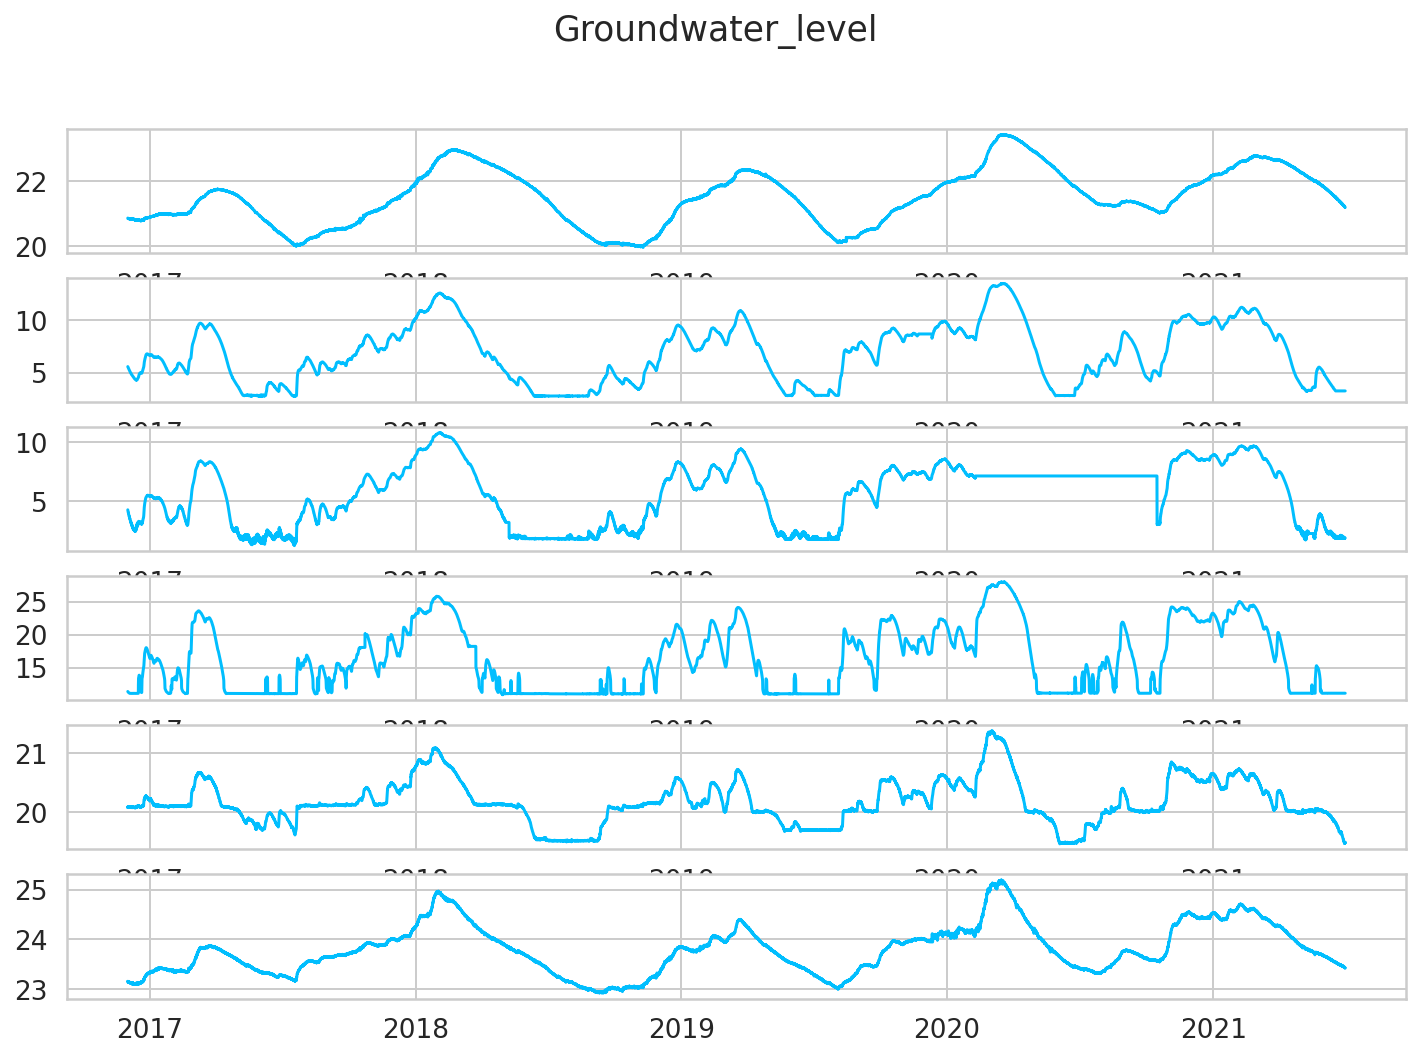

In [ ]:
figure(figsize=(16, 5), dpi=80)
fig, axs = plt.subplots(6)
fig.suptitle('Groundwater_level')

axs[0].plot(df2.index, df2['O2L'])
axs[1].plot(df2.index, df2['O3L'])
axs[2].plot(df2.index, df2['O4L'])
axs[3].plot(df2.index, df2['O5L'])
axs[4].plot(df2.index, df2['O6L'])
axs[5].plot(df2.index, df2['O7L'])

In [ ]:
df2.O2D

Date
2016-12-01 13:00:00    1.131
2016-12-01 14:00:00    1.134
2016-12-01 15:00:00    1.133
2016-12-01 16:00:00    1.126
2016-12-01 17:00:00    1.128
                       ...  
2021-06-30 20:00:00    0.931
2021-06-30 21:00:00    0.928
2021-06-30 22:00:00    0.928
2021-06-30 23:00:00    0.924
2021-07-01 00:00:00    0.925
Name: O2D, Length: 40140, dtype: float64

## Now the data are cleaned for 1 2 3 5 6 7, while 4 is lacking.

## The training data can be from 2017-2020,test data can be later

In [8]:
rows=[]
for _, row in tqdm(df2.iterrows(),total = df2.shape[0]):
  row_data=dict(
      O2L=row.O2L,
      O3L=row.O3L,
      O4L=row.O4L,
      O5L=row.O5L,
      O6L=row.O6L,
      O7L=row.O7L,
      O2D=row.O2D,
      O3D=row.O3D,
      O4D=row.O4D,
      O5D=row.O5D,
      O6D=row.O6D,
      O7D=row.O7D,
      O2E=row.O2E,
      O3E=row.O3E,
      O4E=row.O4E,
      O5E=row.O5E,
      O6E=row.O6E,
      O7E=row.O7E,
      rain=row.rain,
      temp=row.temp,
      vp=row.vp,
      day=row.Day,
      month=row.Month,
      year=row.Year,
      hour=row.Hour
  )
  rows.append(row_data)
features_df=pd.DataFrame(rows)

100%|██████████| 40140/40140 [00:14<00:00, 2729.21it/s]


In [ ]:
features_df

,O2L,O3L,O4L,O5L,O6L,O7L,O2D,O3D,O4D,O5D,O6D,O7D,O2E,O3E,O4E,O5E,O6E,O7E,rain,temp,vp,day,month,year,hour
0,20.861,5.584,4.242,11.362,20.090,23.154,1.131,2.734,4.242,0.282,0.560,0.944,19.73,2.85,0.00,11.08,19.53,22.21,0.0,6.5,7.4,1,12,2016,13
1,20.864,5.581,4.227,11.358,20.094,23.153,1.134,2.731,4.227,0.278,0.564,0.943,19.73,2.85,0.00,11.08,19.53,22.21,0.0,6.8,7.6,1,12,2016,14
2,20.863,5.574,4.208,11.351,20.096,23.156,1.133,2.724,4.208,0.271,0.566,0.946,19.73,2.85,0.00,11.08,19.53,22.21,0.0,6.4,7.5,1,12,2016,15
3,20.856,5.560,4.180,11.336,20.088,23.146,1.126,2.710,4.180,0.256,0.558,0.936,19.73,2.85,0.00,11.08,19.53,22.21,0.0,3.4,6.8,1,12,2016,16
4,20.858,5.556,4.162,11.330,20.090,23.142,1.128,2.706,4.162,0.250,0.560,0.932,19.73,2.85,0.00,11.08,19.53,22.21,0.0,1.5,6.3,1,12,2016,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40135,21.201,3.270,1.856,11.100,19.493,23.425,0.931,0.420,0.126,0.020,-0.007,0.725,20.27,2.85,1.73,11.08,19.50,22.70,0.0,19.7,15.2,30,6,2021,20
40136,21.198,3.270,1.852,11.096,19.488,23.425,0.928,0.420,0.122,0.016,-0.012,0.725,20.27,2.85,1.73,11.08,19.50,22.70,0.0,14.4,13.0,30,6,2021,21
40137,21.198,3.270,1.848,11.098,19.488,23.422,0.928,0.420,0.118,0.018,-0.012,0.722,20.27,2.85,1.73,11.08,19.50,22.70,0.0,11.9,12.2,30,6,2021,22
40138,21.194,3.270,1.848,11.096,19.490,23.421,0.924,0.420,0.118,0.016,-0.010,0.721,20.27,2.85,1.73,11.08,19.50,22.70,0.0,11.9,12.6,30,6,2021,23


In [9]:
train_size= int(len(features_df)*0.6)
val_size=int(len(features_df)*0.85)
test_size=int(len(features_df)*0.95)
print(train_size,val_size,test_size)

24084 34119 38133


In [10]:
train_df=features_df[:train_size]
val_df=features_df[val_size:test_size]
test_df=features_df[test_size:]
print(len(train_df),len(val_df),len(test_df))

24084 4014 2007


# Currently not need transformation, because reverse transformation is difficult.

In [ ]:
scaler=MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(train_df)

In [ ]:
train_df=pd.DataFrame(
    scaler.transform(train_df),
    index=train_df.index,
    columns=train_df.columns
)

In [ ]:
val_df=pd.DataFrame(
    scaler.transform(val_df),
    index=val_df.index,
    columns=val_df.columns
)

In [ ]:
test_df=pd.DataFrame(
    scaler.transform(test_df),
    index=test_df.index,
    columns=test_df.columns
)

# Above are transformation

In [11]:
def create_sequences(input_data:pd.DataFrame,number,TIME_WINDOW,PRED_TIME):
  sequences=[]
  data_size=len(input_data)
  #print(number)
  for i in tqdm(range(data_size-TIME_WINDOW-PRED_TIME)):
    sequence = input_data[i:i+TIME_WINDOW]
    weather_for = input_data.iloc[i+TIME_WINDOW:i+TIME_WINDOW+PRED_TIME,18:21]
    label = input_data.iloc[i+TIME_WINDOW:i+TIME_WINDOW+PRED_TIME,0:number]
    #print(f'label{label}')
    sequences.append((sequence,weather_for,label))
  return sequences


In [ ]:
sample_data=pd.DataFrame(dict(
    feature_1=[1,2,3,4,5,6,7],
    label=[8,9,10,11,12,13,14],
    label2=[8,9,10,11,12,13,14]
))
sample_data.head()

,feature_1,label,label2
0,1,8,8
1,2,9,9
2,3,10,10
3,4,11,11
4,5,12,12


In [ ]:
sample_data.iloc[2:4,0:2]

,feature_1,label
2,3,10
3,4,11


In [ ]:
sample_sequences = create_sequences(sample_data,number=2,TIME_WINDOW=3,PRED_TIME=1)

100%|██████████| 3/3 [00:00<00:00, 1520.78it/s]


In [ ]:
print(sample_sequences[0][0])
print(f'label:{sample_sequences[0][1]}')

   feature_1  label  label2
0          1      8       8
1          2      9       9
2          3     10      10
label:   feature_1  label
3          4     11


In [ ]:
train_df

,O2L,O3L,O4L,O5L,O6L,O7L,O2D,O3D,O4D,O5D,O6D,O7D,O2E,O3E,O4E,O5E,O6E,O7E,rain,temp,vp,day,month,year,hour
0,20.861,5.584,4.242,11.362,20.090,23.154,1.131,2.734,4.242,0.282,0.560,0.944,19.73,2.85,0.00,11.08,19.53,22.21,0.0,6.5,7.4,1,12,2016,13
1,20.864,5.581,4.227,11.358,20.094,23.153,1.134,2.731,4.227,0.278,0.564,0.943,19.73,2.85,0.00,11.08,19.53,22.21,0.0,6.8,7.6,1,12,2016,14
2,20.863,5.574,4.208,11.351,20.096,23.156,1.133,2.724,4.208,0.271,0.566,0.946,19.73,2.85,0.00,11.08,19.53,22.21,0.0,6.4,7.5,1,12,2016,15
3,20.856,5.560,4.180,11.336,20.088,23.146,1.126,2.710,4.180,0.256,0.558,0.936,19.73,2.85,0.00,11.08,19.53,22.21,0.0,3.4,6.8,1,12,2016,16
4,20.858,5.556,4.162,11.330,20.090,23.142,1.128,2.706,4.162,0.250,0.560,0.932,19.73,2.85,0.00,11.08,19.53,22.21,0.0,1.5,6.3,1,12,2016,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24079,20.307,7.562,6.494,18.469,20.164,23.374,0.037,4.712,4.764,7.389,0.664,0.674,20.27,2.85,1.73,11.08,19.50,22.70,0.0,11.7,11.0,31,8,2019,20
24080,20.306,7.568,6.512,18.525,20.163,23.380,0.036,4.718,4.782,7.445,0.663,0.680,20.27,2.85,1.73,11.08,19.50,22.70,0.0,11.0,10.9,31,8,2019,21
24081,20.311,7.583,6.520,18.557,20.168,23.381,0.041,4.733,4.790,7.477,0.668,0.681,20.27,2.85,1.73,11.08,19.50,22.70,0.0,10.6,10.6,31,8,2019,22
24082,20.309,7.597,6.537,18.607,20.169,23.377,0.039,4.747,4.807,7.527,0.669,0.677,20.27,2.85,1.73,11.08,19.50,22.70,0.0,10.1,10.5,31,8,2019,23


In [ ]:
val_df

,O2L,O3L,O4L,O5L,O6L,O7L,O2D,O3D,O4D,O5D,O6D,O7D,O2E,O3E,O4E,O5E,O6E,O7E,rain,temp,vp,day,month,year,hour
34119,21.048,6.014,4.630,15.946,20.066,23.607,0.778,3.164,2.900,4.866,0.566,0.907,20.27,2.85,1.73,11.08,19.5,22.7,0.1,8.1,10.0,23,10,2020,4
34120,21.051,6.013,4.630,15.940,20.067,23.607,0.781,3.163,2.900,4.860,0.567,0.907,20.27,2.85,1.73,11.08,19.5,22.7,0.0,6.8,9.1,23,10,2020,5
34121,21.051,6.015,4.635,15.936,20.069,23.613,0.781,3.165,2.905,4.856,0.569,0.913,20.27,2.85,1.73,11.08,19.5,22.7,0.2,6.4,8.3,23,10,2020,6
34122,21.052,6.017,4.635,15.938,20.077,23.613,0.782,3.167,2.905,4.858,0.577,0.913,20.27,2.85,1.73,11.08,19.5,22.7,0.0,6.5,7.9,23,10,2020,7
34123,21.051,6.025,4.645,15.936,20.070,23.614,0.781,3.175,2.915,4.856,0.570,0.914,20.27,2.85,1.73,11.08,19.5,22.7,0.0,5.6,8.0,23,10,2020,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38128,22.580,7.953,6.786,16.544,20.166,24.188,2.310,5.103,5.056,5.464,0.666,1.488,20.27,2.85,1.73,11.08,19.5,22.7,0.0,6.5,8.0,8,4,2021,5
38129,22.581,7.945,6.781,16.522,20.163,24.186,2.311,5.095,5.051,5.442,0.663,1.486,20.27,2.85,1.73,11.08,19.5,22.7,0.0,7.1,8.1,8,4,2021,6
38130,22.579,7.937,6.773,16.504,20.161,24.187,2.309,5.087,5.043,5.424,0.661,1.487,20.27,2.85,1.73,11.08,19.5,22.7,0.0,7.4,8.0,8,4,2021,7
38131,22.574,7.931,6.767,16.482,20.156,24.183,2.304,5.081,5.037,5.402,0.656,1.483,20.27,2.85,1.73,11.08,19.5,22.7,0.1,6.9,7.8,8,4,2021,8


In [12]:
number=6
TIME_WINDOW=720
PRED_TIME=72
train_sequences=create_sequences(train_df,number,TIME_WINDOW,PRED_TIME)
val_sequences=create_sequences(val_df,number,TIME_WINDOW,PRED_TIME)
test_sequences=create_sequences(test_df,number,TIME_WINDOW,PRED_TIME)

100%|██████████| 1215/1215 [00:00<00:00, 1469.69it/s]


In [ ]:
print(len(train_sequences)/128)

186.09375


In [12]:
print(train_sequences[0][0].shape)
print(train_sequences[0][1].shape)
print(train_sequences[0][2].shape)

(720, 25)
(72, 3)
(72, 6)


In [ ]:
#Don't need now
O1L=df2['O1L'].to_numpy()
print(O1L.shape)
O2L=df2['O2L'].to_numpy()
O3L=df2['O3L'].to_numpy()
O4L=df2['O4L'].to_numpy()
O5L=df2['O5L'].to_numpy()
O6L=df2['O6L'].to_numpy()
O7L=df2['O7L'].to_numpy()
print(O4L.shape)
O1E=df2['O1E'].to_numpy()
print(O1L.shape)
O2E=df2['O2E'].to_numpy()
O3E=df2['O3E'].to_numpy()
O4E=df2['O4E'].to_numpy()
O5E=df2['O5E'].to_numpy()
O6E=df2['O6E'].to_numpy()
O7E=df2['O7E'].to_numpy()
rain=df2['rain'].to_numpy()
temp=df2['temp'].to_numpy()
vp=df2['Vapour Pressure '].to_numpy()
Day=df2['Day'].to_numpy()
Month=df2['Month'].to_numpy()
Year=df2['Year'].to_numpy()
Hour=df2['Hour'].to_numpy()

(40140,)
(40140,)
(40140,)


KeyError: ignored

In [13]:

Well_location= pd.read_csv(os.path.join(DATA_PATH,'sets.csv'))

NE=[]
North=[]
East=[]
for i in range(2,8):
    N=Well_location.iloc[0][i]
    North.append(N)
    E=Well_location.iloc[1][i]
    East.append(E)
    NE.append((N,E))
print(len(NE))
print(NE)
print(North)
print(East)

6
[(53.022037, 8.873746), (53.086776, 8.849339), (53.104572999999995, 8.870828), (53.121168999999995, 8.751982), (53.139996, 8.804413), (53.184284999999996, 8.810231)]
[53.022037, 53.086776, 53.104572999999995, 53.121168999999995, 53.139996, 53.184284999999996]
[8.873746, 8.849339, 8.870828, 8.751982, 8.804413, 8.810231]


In [14]:
from math import sin, cos, sqrt, atan2, radians
R = 6378.1370
specific_distance=7
def get_conn_attr(N,E):
    Distance = []
    con_i=[]
    con_j=[]
    for i in range(len(N)):
        for j in range(len(N)):
          #print('this is Ni',N[i],E[i])
          lat1 = radians(N[i])
          lon1 = radians(E[i])
          lat2 = radians(N[j])
          lon2 = radians(E[j])
          dlon = lon2 - lon1
          dlat = lat2 - lat1
          a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
          c = 2 * atan2(sqrt(a), sqrt(1 - a))
          distance = R * c
          if (distance < specific_distance) & (distance > 0):
              con_i.append(i)
              con_j.append(j)
              Distance.append(distance)

    conn=torch.tensor([con_i,con_j])
    edge_attr = torch.tensor([Distance])
    edge_attr = edge_attr.transpose(0, 1) 
    edge_attr = edge_attr.unsqueeze(0).repeat(6,1,1)
    return conn, edge_attr

In [15]:
Conn,Edge_attr=get_conn_attr(North,East)
print(Conn.shape)
print(Edge_attr.shape)

torch.Size([2, 10])
torch.Size([6, 10, 1])


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
import os
import json
import numpy as np
import pandas as pd
from math import sin, cos, sqrt, atan2, radians





In [ ]:
type(conn)

torch.Tensor

In [17]:
class WellDataset(Dataset):
  def __init__(self,sequences,conn,edge_attr):
    self.sequences= sequences
    self.conn=conn
    self.edge_attr=edge_attr
  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, index):
    sequence,weather_for,label=self.sequences[index]
    return dict(
        sequence=torch.Tensor(sequence.to_numpy()),
        weather_for=torch.Tensor(weather_for.to_numpy()),
        conn=self.conn,
        edge_attr=self.edge_attr,
        label= torch.Tensor(label.to_numpy()).float()       
    )

In [18]:
class WellDataModule(pl.LightningDataModule):
  def __init__(
      self, train_sequences, val_sequences,test_sequences,North,East,batch_size
  ):
    super().__init__()
    self.conn=Conn
    self.edge_attr=Edge_attr
    self.train_sequences=train_sequences
    self.val_sequences=val_sequences
    self.test_sequences=test_sequences
    self.batch_size=batch_size
  def setup(self):
    self.train_dataset= WellDataset(self.train_sequences,self.conn,self.edge_attr)
    self.val_dataset= WellDataset(self.val_sequences,self.conn,self.edge_attr)
    self.test_dataset=WellDataset(self.test_sequences,self.conn,self.edge_attr)
  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2
    )
  def val_dataloader(self):
    return DataLoader(
        self.val_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=2
    )
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=2
    )

In [ ]:
test_dataset= WellDataset(val_sequences,Conn,Edge_attr)
for item in test_dataset:
  print(item.keys())
  print(item['conn'].shape)
  print(item['edge_attr'].shape)
  print(item['sequence'])
  break

dict_keys(['sequence', 'weather_for', 'conn', 'edge_attr', 'label'])
torch.Size([2, 10])
torch.Size([6, 10, 1])
tensor([[-0.2781, -0.3327, -0.2845,  ...,  0.6364,  1.6667, -0.6522],
        [-0.2761, -0.3329, -0.2845,  ...,  0.6364,  1.6667, -0.5652],
        [-0.2761, -0.3325, -0.2835,  ...,  0.6364,  1.6667, -0.4783],
        ...,
        [-0.1289,  0.2356,  0.3277,  ...,  0.8182,  1.6667, -0.9130],
        [-0.1309,  0.2366,  0.3287,  ...,  0.8182,  1.6667, -0.8261],
        [-0.1295,  0.2403,  0.3338,  ...,  0.8182,  1.6667, -0.7391]])


# Model

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean, scatter_add
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
device

device(type='cuda')

In [21]:
class RNNEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNEncoder, self).__init__()
        self.input_size=input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)

    def forward(self, x, h0, c0):
        # Set initial hidden and cell states
        # Forward propagate LSTM
        out, (h_n, c_n) = self.lstm(x, (h0, c0))  
        # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        #print('encoder shape',h_n.shape,c_n.shape)
        return h_n, c_n
class RNNDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNDecoder, self).__init__()
        self.input_size=input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.lin = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        #print('this is hidden size in RNN decoder',hidden_size)

    def forward(self, x, h_0, c_0):
        # Forward propagate LSTM
        out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.lin(out)
        out = self.relu(out)
        #print("inside the RNNDecoder",out.shape)
        # Decode the hidden state of the last time step
        return out, h_n, c_n

In [86]:

class WellModel(nn.Module):
  def __init__(self, L_em,D_em,E_em,T_em, W_em,well_num, rnn_h, rnn_l, gnn_h):
    super(WellModel,self).__init__()
    self.L_em=L_em
    self.D_em=D_em
    self.E_em=E_em
    self.T_em=T_em
    self.W_em=W_em
    self.well_num=well_num
    self.rnn_h=rnn_h
    self.gnn_h=gnn_h
    self.rnn_l=rnn_l

    self.L_embed = nn.Sequential(
      nn.Linear(1,self.L_em),
      nn.ReLU()
    )
    self.E_embed = nn.Sequential(
      nn.Linear(1,self.E_em),
      nn.ReLU()
    )
    self.D_embed = nn.Sequential(
      nn.Linear(1,self.D_em),
      nn.ReLU()
    )
    self.T_embed = nn.Sequential(
      nn.Linear(4,self.T_em),
      nn.ReLU()
    )
    self.W_embed = nn.Sequential(
      nn.Linear(3,self.W_em),
      nn.ReLU()
    )    
    self.well_gnn=WellGNN(64,1,self.gnn_h) # node feature is the sum of em, edge feature is 1
    self.encoder = RNNEncoder(input_size=self.gnn_h,
                  hidden_size=self.rnn_h,
                  num_layers=self.rnn_l)
    self.decoder_embed=nn.Sequential(
      nn.Linear(1,self.L_em),            
      nn.ReLU()            
    )
    self.decoder=RNNDecoder(input_size=self.L_em+self.W_em,
                hidden_size=self.rnn_h,
                num_layers=self.rnn_l)
  def batchInput(self,x,edge_w,edge_conn):
    x=x.reshape(-1,x.shape[-1])
    edge_w=edge_w.reshape(-1,edge_w.shape[-1])    
    for i in range(edge_conn.size(0)):
      edge_conn[i,:]=torch.add(edge_conn[i,:],i*self.well_num) 
    edge_conn=edge_conn.transpose(0,1)                     
    edge_conn=edge_conn.reshape(2,-1)
    return x,edge_w,edge_conn
  def forward(self,data,device):
    device=device
    #print(features.shape)
    #print(weather_for.shape)
    features= data['sequence'].to(device)
    weather_for=data['weather_for'].to(device)
    conn=data['conn'].to(device)
    edge_attr=data['edge_attr'].to(device)
    #print(features.is_cuda)
    L=features[:,:,:6]
    D=features[:,:,6:12]
    E=features[:,:,12:18]
    W=features[:,:,18:21]
    T=features[:,:,[23,22,21,24]]
    #print('L',L.is_cuda)
    Lev=L.unsqueeze(dim=-1).to(torch.float32)
    Lev=self.L_embed(Lev)
    
    Dif=D.unsqueeze(dim=-1).to(torch.float32)
    Dif=self.D_embed(Dif)

    Ele=E.unsqueeze(dim=-1).to(torch.float32)
    Ele=self.E_embed(Ele)

    Wea=W.unsqueeze(dim=-2).to(torch.float32)
    Wea=self.W_embed(Wea)
    Wea=Wea.repeat(1,1,6,1)

    Tim=T.unsqueeze(dim=-2).to(torch.float32)
    Tim=self.T_embed(Tim)
    Tim=Tim.repeat(1,1,6,1)
    #print("Four features size",Lev.shape,Ele.shape,Wea.shape,Tim.shape)
    x=torch.cat([Lev,Dif,Ele,Wea,Tim],dim=-1) #16+16+8+8+16
    #print('x=torch.cat([Lev,Dif,Ele,Wea,Tim],dim=-1) ',x.is_cuda)
    #print("x before torch.cat",x.shape)
    conn=conn.repeat(self.well_num,1,1).to(torch.float32) # 128,2,10 -> 128*6,2,10
    edge_attr = edge_attr.reshape(-1, edge_attr.shape[-2], edge_attr.shape[-1]).to(torch.float32) # (128*6,10,1) -> 
    #print('This is x.shape,conn.shape,edge_attr.shape',x.shape,conn.shape,edge_attr.shape)
    #print('edge conn ',conn.is_cuda,edge_attr)
    x, edge_attr, conn = self.batchInput(x, edge_attr, conn) #x (128,24,6,64) -> (128*24*6,64); conn (128*6,2,10) -> ? ; edge_attr (128*6,10,1) -> (128*6*10,1)
    
    #print(x.is_cuda)
    x = self.well_gnn(x, conn,edge_attr,device )
    #print(x.is_cuda)
    x = x.reshape(-1, TIME_WINDOW, self.well_num, x.shape[-1]).transpose(1, 2)
    x = x.reshape(-1, TIME_WINDOW, x.shape[-1])
    
    h0 = torch.randn(self.rnn_l, x.size(0), self.rnn_h).to(device)
    c0 = torch.randn(self.rnn_l, x.size(0), self.rnn_h).to(device)
    h_x, c_x = self.encoder(x, h0, c0)

    outputs = torch.zeros((x.size(0), weather_for.size(1), 1)).to(device)
    #print("cudahco",h0.is_cuda,c0.is_cuda,outputs.is_cuda)
    QL=L.transpose(1,2).to(torch.float32)
    QL=QL[:, :, -1].reshape(-1, 1)
    weather_for=weather_for.repeat(self.well_num,1,1).to(torch.float32)
    weather_for=self.W_embed(weather_for)

    for i in range(weather_for.size(1)):
      QL_em=self.decoder_embed(QL)
      inputs=torch.cat((QL_em,weather_for[:,i]),dim=-1)
      #print('here ok',inputs.shape)
      inputs=inputs.unsqueeze(dim=1)
      #print('here is ok',inputs.shape)
      output,h_x,c_x=self.decoder(inputs,h_x,c_x)
      #print('here is outputs shape',output.shape)
      output = output.reshape(-1,1)
      outputs[:,i]=output
      QL=output
    outputs=outputs.reshape(-1,self.well_num,weather_for.size(1))
    #print("output.shape",outputs.shape)
    return outputs

class WellGNN(torch.nn.Module):
  def __init__(self,node_h=64,edge_h=1,gnn_h=32):
    super(WellGNN,self).__init__()
    self.node_mlp_1 =nn.Sequential(
      nn.Linear(2 * node_h + edge_h, gnn_h),
      nn.ReLU(inplace=True)
    )

    self.node_mlp_2 =nn.Sequential(
      nn.Linear(node_h + gnn_h, gnn_h),
      nn.ReLU(inplace=True)
    )
  def forward(self, x, edge_index, edge_attr,device):
    # x: [N, F_x], where N is the number of nodes.
    # edge_index: [2, E] with max entry N - 1.
    # edge_attr: [E, F_e]
    #u = u.reshape(-1, u.shape[-1])
    #u = u.repeat(sta_num, 1)
    device=device
    x=x.to(device)
    edge_index=edge_index.to(device)
    edge_attr=edge_attr.to(device)
    #print('edge_index',edge_index.is_cuda)
    row, col = edge_index
    row = row.type(torch.LongTensor).to(device)
    col = col.type(torch.LongTensor).to(device) # need to be torch.longTensor type

    #torch.LongTensor(rows)    
    #print('col',col.is_cuda)
    out = torch.cat([x[row], x[col], edge_attr], dim=1)
    #print('out',out.is_cuda)
    out = self.node_mlp_1(out)
    #print('out',out.is_cuda)
    out = scatter_mean(out, col, dim=0, dim_size=x.size(0)).to(device)
    #print('out',out.is_cuda)
    out = torch.cat([x, out], dim=1)
    #print('out',out.is_cuda) #delete u
    return self.node_mlp_2(out)

In [ ]:
aa=torch.rand((2,3,4))
print(aa)
for i in range(2):
  print(torch.add(aa[i,:],i*1))

tensor([[[0.0225, 0.2069, 0.1905, 0.6976],
         [0.2633, 0.0243, 0.8840, 0.8077],
         [0.8102, 0.5244, 0.4053, 0.7936]],

        [[0.6692, 0.5132, 0.1596, 0.2625],
         [0.5192, 0.7520, 0.1189, 0.2500],
         [0.5078, 0.4950, 0.7206, 0.8080]]])
tensor([[0.0225, 0.2069, 0.1905, 0.6976],
        [0.2633, 0.0243, 0.8840, 0.8077],
        [0.8102, 0.5244, 0.4053, 0.7936]])
tensor([[1.6692, 1.5132, 1.1596, 1.2625],
        [1.5192, 1.7520, 1.1189, 1.2500],
        [1.5078, 1.4950, 1.7206, 1.8080]])


In [ ]:
xx=torch.rand((128*24*6,16))
yy=torch.rand((128*24*6,16))
torch.cat([xx,yy],dim=-1).shape

torch.Size([18432, 32])

In [83]:
TIME_WINDOW=720
PRED_TIME=72
L_em=16
D_em=16
E_em=8
T_em=8
W_em=16
well_num=6
rnn_h=64
gnn_h=32
rnn_l=1
lr=0.001
Epoch=10
BATCH_SIZE=128

In [87]:
model=WellModel(L_em,D_em, E_em,T_em, W_em,well_num, rnn_h, rnn_l, gnn_h).to(device)
model_num = sum(p.numel() for p in model.parameters()
                      if p.requires_grad)
print('model:', 'Trainable,', model_num)
criterion = nn.MSELoss()
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.001)
print(device)
val_loss_min = 0.01
data_module=WellDataModule(train_sequences,val_sequences,test_sequences,Conn,Edge_attr,batch_size=BATCH_SIZE)
data_module.setup()

model: Trainable, 57721
cuda


In [31]:
model = WellModel(L_em,D_em, E_em,T_em, W_em,well_num, rnn_h, rnn_l, gnn_h).to(device)
model.load_state_dict(torch.load(F"/content/gdrive/My Drive/temp_model4:0.ckpt"))
model_num = sum(p.numel() for p in model.parameters()
                      if p.requires_grad)
print('model:', 'Trainable,', model_num)
criterion = nn.MSELoss()
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.001)

val_loss_min = 0.01
data_module=WellDataModule(train_sequences,val_sequences,test_sequences,Conn,Edge_attr,batch_size=BATCH_SIZE)
data_module.setup()

model: Trainable, 57721


In [ ]:
test=iter(data_module.train_dataloader())
data=test.next()
print(data.keys())
#print(data['sequence'])
print(data['conn'])


In [89]:
#@title 默认标题文本
a=[]
b=[]
c=[]
d=[]
for epoch in range(Epoch):
  for i,data in enumerate(data_module.train_dataloader()):
    data=data

    label=data['label'].transpose(1,2).to(device) #128*24*7 -> 128*7*24
    #sequences=[features,weather_for,conn,edge_attr]
    #print(sequences.is_cuda())
    outputs = model(data,device)
    #print('label',label.shape)
    a.append((outputs,label))
    
    loss = criterion(outputs, label)
    b.append(loss.item())
    #a.append(loss.item())
    model.zero_grad()
    loss =loss
    loss.backward() 
    optimizer.step()
    if i % 1 ==0 and epoch % 1 ==0:
      print("Epoch [{}/{}], step [{}/{}],loss {:.4f} ".format(
          epoch,10,i,int(len(train_sequences)/BATCH_SIZE),loss.item()
      ))
  val_loss=0
  with torch.no_grad():
    for j,data in enumerate(data_module.val_dataloader()):
      
      data = data
      label=data['label'].transpose(1,2).to(device)
      outputs = model(data,device)
      c.append((outputs,label))  


      val_loss= criterion(outputs, label)
      d.append(val_loss.item())
      if epoch % 1 ==0 and j==0:
        print("Epoch [{}/{}], step [{}/{}],loss {:.4f} ".format(
          epoch,10,j,int(len(test_sequences)/BATCH_SIZE),val_loss.item()
      ))
        name = F'temp_model{epoch}:{j}.ckpt'
        path = F"/content/gdrive/My Drive/{name}" 
        torch.save(model.state_dict(), path)
        

    if val_loss < val_loss_min and epoch > (Epoch * 0.7):
      print('Model can be saved')
      model_save_name = F'FINAL_Ireland_well{epoch}.ckpt'
      path = F"/content/gdrive/My Drive/{model_save_name}" 
      torch.save(model.state_dict(), path)  
      #torch.save(model.state_dict(),'./checkpoints/global.ckpt')
    
      val_loss_min = val_loss
print('Finished Training')


Epoch [0/10], step [0/181],loss 54.1862 
Epoch [0/10], step [1/181],loss 54.6240 
Epoch [0/10], step [2/181],loss 54.8309 
Epoch [0/10], step [3/181],loss 57.1711 
Epoch [0/10], step [4/181],loss 63.3005 
Epoch [0/10], step [5/181],loss 65.9886 
Epoch [0/10], step [6/181],loss 66.4282 
Epoch [0/10], step [7/181],loss 63.3162 
Epoch [0/10], step [8/181],loss 65.5531 
Epoch [0/10], step [9/181],loss 68.3391 
Epoch [0/10], step [10/181],loss 68.5707 
Epoch [0/10], step [11/181],loss 73.8558 
Epoch [0/10], step [12/181],loss 75.5616 
Epoch [0/10], step [13/181],loss 72.7345 
Epoch [0/10], step [14/181],loss 71.6251 
Epoch [0/10], step [15/181],loss 70.3201 
Epoch [0/10], step [16/181],loss 64.3927 
Epoch [0/10], step [17/181],loss 59.1958 
Epoch [0/10], step [18/181],loss 57.7101 
Epoch [0/10], step [19/181],loss 61.1136 
Epoch [0/10], step [20/181],loss 67.9974 
Epoch [0/10], step [21/181],loss 72.2294 
Epoch [0/10], step [22/181],loss 74.3042 
Epoch [0/10], step [23/181],loss 76.7818 
Ep

In [ ]:

model_save_name = F'FINAL_Ireland_well9.ckpt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)  

In [90]:
print(len(a))
print(len(b))
print(len(c))
print(len(d))

1820
1820
32220
32220


In [91]:
train_outputs=[]
train_y=[]
for i in range(len(a)):
  train_outputs.append(a[i][0])
  train_y.append(a[i][1])
print(len(train_outputs))

1820


In [92]:
val_outputs=[]
val_y=[]
for i in range(len(c)):
  val_outputs.append(c[i][0])
  val_y.append(c[i][1])
print(len(val_outputs))

32220


In [93]:
torch.save(train_outputs, F"/content/gdrive/My Drive/train_outputs.pt")

In [94]:
torch.save(train_y, F"/content/gdrive/My Drive/train_y.pt")

In [95]:
torch.save(val_outputs, F"/content/gdrive/My Drive/val_outputs.pt")

In [96]:
torch.save(val_y, F"/content/gdrive/My Drive/val_y.pt")

In [97]:
torch.save(b, F"/content/gdrive/My Drive/train_loss.pt")

In [98]:
torch.save(d, F"/content/gdrive/My Drive/val_loss.pt")

In [129]:
new_outputs=torch.load(F"/content/gdrive/My Drive/val_outputs.pt")
new_y=torch.load(F"/content/gdrive/My Drive/val_y.pt")
print(new_outputs[2500])
print(new_y[2500]) 

tensor([[[12.3308, 13.0571, 13.1196, 13.0651, 13.0376, 13.0309, 13.0319,
          13.0342, 13.0360, 13.0392, 13.0425, 13.0459, 13.0499, 13.0533,
          13.0569, 13.0600, 13.0619, 13.0637, 13.0650, 13.0665, 13.0679,
          13.0690, 13.0699, 13.0708, 13.0713, 13.0715, 13.0714, 13.0709,
          13.0708, 13.0708, 13.0710, 13.0724, 13.0735, 13.0740, 13.0744,
          13.0749, 13.0754, 13.0757, 13.0759, 13.0761, 13.0762, 13.0764,
          13.0766, 13.0767, 13.0768, 13.0768, 13.0768, 13.0768, 13.0767,
          13.0761, 13.0747, 13.0732, 13.0734, 13.0742, 13.0746, 13.0749,
          13.0753, 13.0754, 13.0755, 13.0756, 13.0757, 13.0759, 13.0756,
          13.0759, 13.0766, 13.0770, 13.0772, 13.0766, 13.0764, 13.0761,
          13.0758, 13.0769],
         [10.9851, 12.5113, 12.8467, 12.9143, 12.9307, 12.9383, 12.9456,
          12.9518, 12.9565, 12.9631, 12.9705, 12.9791, 12.9893, 12.9989,
          13.0091, 13.0187, 13.0262, 13.0329, 13.0384, 13.0436, 13.0482,
          13.0522, 13.

In [123]:
print(len(val_sequences)*10-3222)

28998


In [140]:
o0=[]
p0=[]
o1=[]
p1=[]
o2=[]
p2=[]
o3=[]
p3=[]
o4=[]
p4=[]
o5=[]
p5=[]
for i in range(28998,32221,72):
  for j in range(72):
    o0.append(new_outputs[i][0][0][j].item())
    p0.append(new_y[i][0][0][j].item())
    o1.append(new_outputs[i][0][1][j].item())
    p1.append(new_y[i][0][1][j].item())
    o2.append(new_outputs[i][0][2][j].item())
    p2.append(new_y[i][0][2][j].item())
    o3.append(new_outputs[i][0][3][j].item())
    p3.append(new_y[i][0][3][j].item())

    o4.append(new_outputs[i][0][4][j].item())
    p4.append(new_y[i][0][4][j].item())
    o5.append(new_outputs[i][0][5][j].item())
    p5.append(new_y[i][0][5][j].item())

  

In [148]:
o0=torch.tensor(o0).to('cpu')
p0=torch.tensor(p0).to('cpu')
o1=torch.tensor(o1).to('cpu')
p1=torch.tensor(p1).to('cpu')
o2=torch.tensor(o2).to('cpu')
p2=torch.tensor(p2).to('cpu')
o3=torch.tensor(o3).to('cpu')
p3=torch.tensor(p3).to('cpu')
o4=torch.tensor(o4).to('cpu')
p4=torch.tensor(p4).to('cpu')
o5=torch.tensor(o5).to('cpu')
p5=torch.tensor(p5).to('cpu')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy 

tensor([22.7470, 22.7470, 22.7470, 22.7490, 22.7490, 22.7560, 22.7530, 22.7500,
        22.7520, 22.7540, 22.7530, 22.7520, 22.7550, 22.7530, 22.7530, 22.7540,
        22.7550, 22.7570, 22.7550, 22.7540, 22.7550, 22.7530, 22.7520, 22.7520,
        22.7570, 22.7570, 22.7550, 22.7590, 22.7560, 22.7620, 22.7590, 22.7610,
        22.7640, 22.7630, 22.7640, 22.7640, 22.7640, 22.7660, 22.7670, 22.7690,
        22.7660, 22.7810, 22.7660, 22.7630, 22.7600, 22.7630, 22.7630, 22.7630,
        22.7610, 22.7610, 22.7620, 22.7640, 22.7680, 22.7720, 22.7680, 22.7670,
        22.7720, 22.7710, 22.7720, 22.7740, 22.7710, 22.7690, 22.7710, 22.7750,
        22.7720, 22.7760, 22.7760, 22.7640, 22.7660, 22.7630, 22.7640, 22.7640],
       device='cuda:0')


<Figure size 1600x640 with 0 Axes>

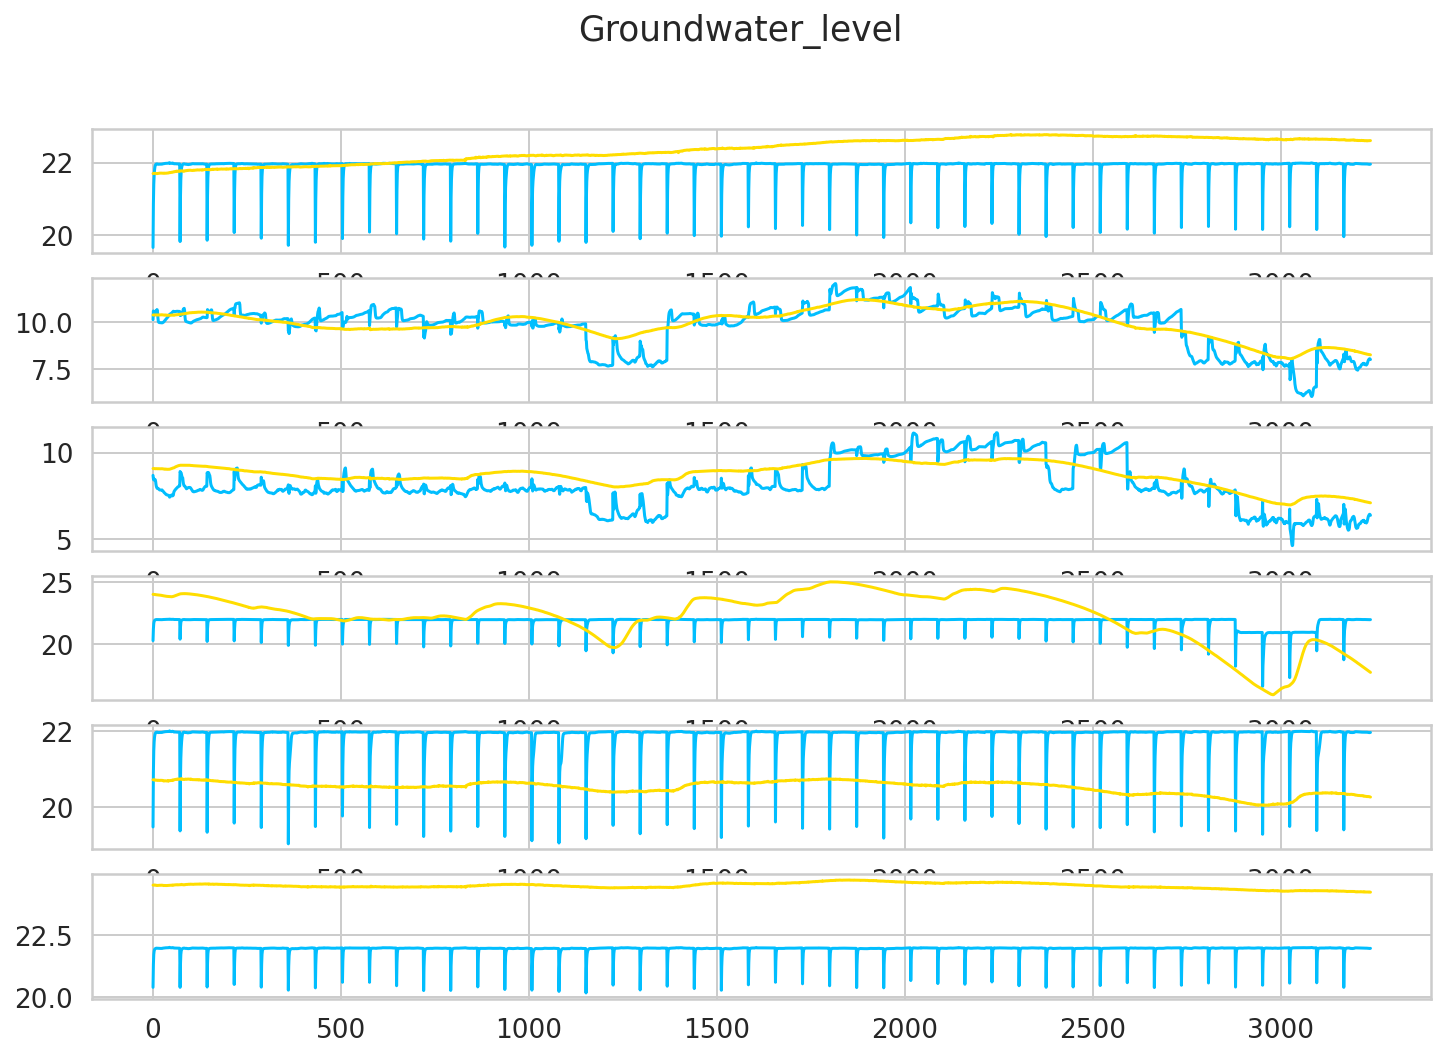

In [149]:
x=range(3240)
figure(figsize=(20, 8), dpi=80)
fig, axs = plt.subplots(6)
fig.suptitle('Groundwater_level')
print(new_y[31240][0][0])
axs[0].plot(x, o0,p0)
axs[1].plot(x, o1,p1)
axs[2].plot(x, o2,p2)
axs[3].plot(x, o3,p3)
axs[4].plot(x, o4,p4)
axs[5].plot(x, o5,p5)

torch.Size([1, 6, 24])
tensor(0.0180)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.1554, 0.1529, 0.1504, 0.1529, 0.1504, 0.1454, 0.1504, 0.1391, 0.1404,
        0.1353, 0.1303, 0.1341, 0.1266, 0.1316, 0.1253, 0.1253, 0.1266, 0.1266,
        0.1216, 0.1241, 0.1203, 0.1140, 0.1153, 0.1153])


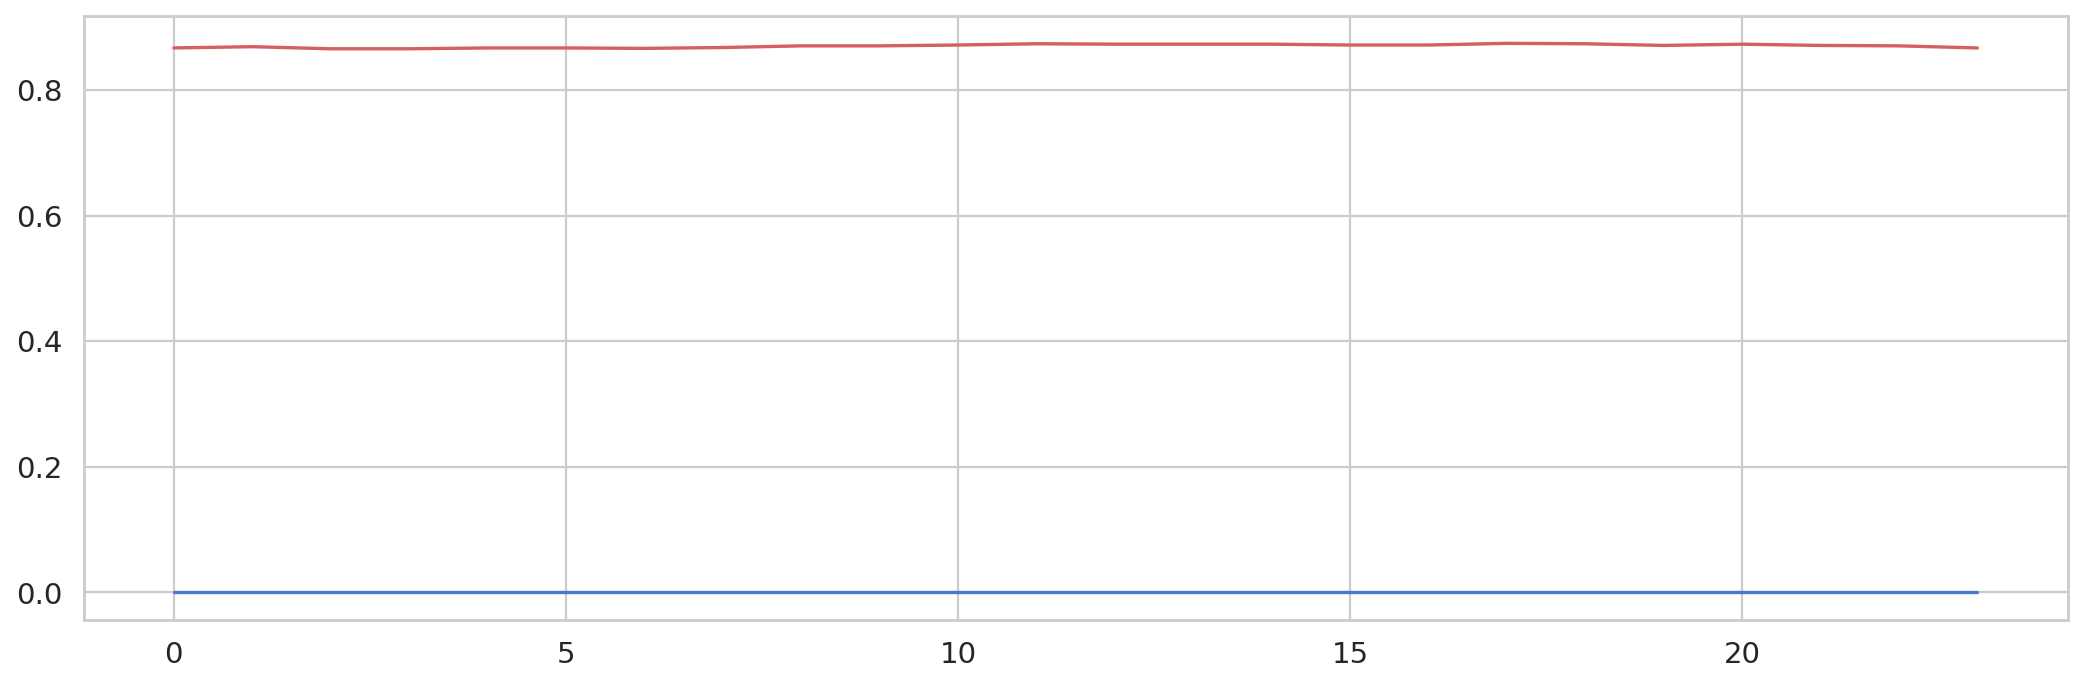

In [ ]:
print(val_outputs[2999].shape)
print(criterion(val_outputs[2999][0][4],val_y[2999][0][4],))
print(val_outputs[2000][0][4])
print(val_y[2999][0][4])
x=range(24)
figure(figsize=(16, 5), dpi=80)

fig.suptitle('Groundwater_level')

plt.plot(x,val_outputs[2840][0][0],'b',val_y[2840][0][0],'r')



In [ ]:
with open("test.txt", "r") as fp:
     b = json.load(fp)

In [ ]:
for item in a:
  print(item[0].shape)
  print(item[1].shape)
  print(criterion(item[0], item[1]))
  print(criterion(item[0][1,1,1],item[1][1,1,1]))
  print(criterion(item[0][127,6,23],item[1][127,6,23]))
  break

torch.Size([128, 7, 24])
torch.Size([128, 7, 24])
tensor(968.9291, grad_fn=<MseLossBackward>)
tensor(432.8065, grad_fn=<MseLossBackward>)
tensor(534.4420, grad_fn=<MseLossBackward>)


In [ ]:
for item in c:
  print(item[0].shape)
  print(item[1].shape)
  print(criterion(item[0], item[1]))
  print(criterion(item[0][0,1,23],item[1][0,1,23]))

  break

torch.Size([1, 7, 24])
torch.Size([1, 7, 24])
tensor(587.6411)
tensor(48.1752)


In [ ]:
for epoch in range(3):
  model_save_name = F'Ireland_well{epoch}.ckpt'
  path = F"/content/gdrive/My Drive/{model_save_name}" 
  torch.save(model.state_dict(), path) 
  for j in range(3):
    if epoch % 1 ==0 and j==0:
      name = F'temp_model{epoch}:{j}.ckpt'
      path = F"/content/gdrive/My Drive/{name}" 
      torch.save(model.state_dict(), path)